# Project:**Token-Level Multi-Class Classification**

In [ ]:
# necessary packages
!pip install -q tensorflow
!pip install -q keras
!pip install -q seaborn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, Bidirectional, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import ast
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# CRITICAL: Force eager execution
print("Forcing eager execution...")
tf.config.run_functions_eagerly(True)
print(f"Eager execution is {'enabled' if tf.executing_eagerly() else 'disabled'}")


Forcing eager execution...
Eager execution is enabled


In [ ]:
# reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
print("Loading datasets...")
train_df = pd.read_csv('/content/Dataset_B_POS_train.csv')
test_df = pd.read_csv('/content/Dataset_B_POS_test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")
# Display sample data
print("Training data sample:")
display(train_df.head())
print("\nTest data sample:")
display(test_df.head())

Loading datasets...
Training set shape: (19184, 3)
Testing set shape: (4796, 3)
Training data sample:


,Sentence #,Sentence,POS
0,1,Yemen 's official news agency reports Sunday t...,"['NNP', 'POS', 'JJ', 'NN', 'NN', 'VBZ', 'NNP',..."
1,2,"In other news , a suicide bomb attack in north...","['IN', 'JJ', 'NN', ',', 'DT', 'NN', 'NN', 'NN'..."
2,3,A Lion had come to the end of his days and lay...,"['DT', 'NN', 'VBD', 'VBN', 'TO', 'DT', 'NN', '..."
3,4,The case involves the leak of the identity of ...,"['DT', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'DT', 'N..."
4,5,The statement quoted Mr. Yushchenko as telling...,"['DT', 'NN', 'VBD', 'NNP', 'NNP', 'IN', 'VBG',..."



Test data sample:


,Sentence #,Sentence,POS
0,1,This remarkable achievement has been reflected...,"['DT', 'JJ', 'NN', 'VBZ', 'VBN', 'VBN', 'IN', ..."
1,2,With the addition of the midwestern state of I...,"['IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN..."
2,3,President Musharraf had planned to attend the ...,"['NNP', 'NNP', 'VBD', 'VBN', 'TO', 'VB', 'DT',..."
3,4,Negotiations are expected to resume the week o...,"['NNS', 'VBP', 'VBN', 'TO', 'VB', 'DT', 'NN', ..."
4,5,The Organization of American States has reject...,"['DT', 'NNP', 'IN', 'NNP', 'NNP', 'VBZ', 'VBN'..."


In [ ]:
print("Checking for null values in training data:")
print(train_df.isnull().sum())

print("\nChecking for null values in testing data:")
print(test_df.isnull().sum())


Checking for null values in training data:
Sentence #    0
Sentence      0
POS           0
dtype: int64

Checking for null values in testing data:
Sentence #    0
Sentence      0
POS           0
dtype: int64


In [ ]:
# text cleaning
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    text = text.strip()
    return text

train_df['Sentence'] = train_df['Sentence'].apply(clean_text)
test_df['Sentence'] = test_df['Sentence'].apply(clean_text)


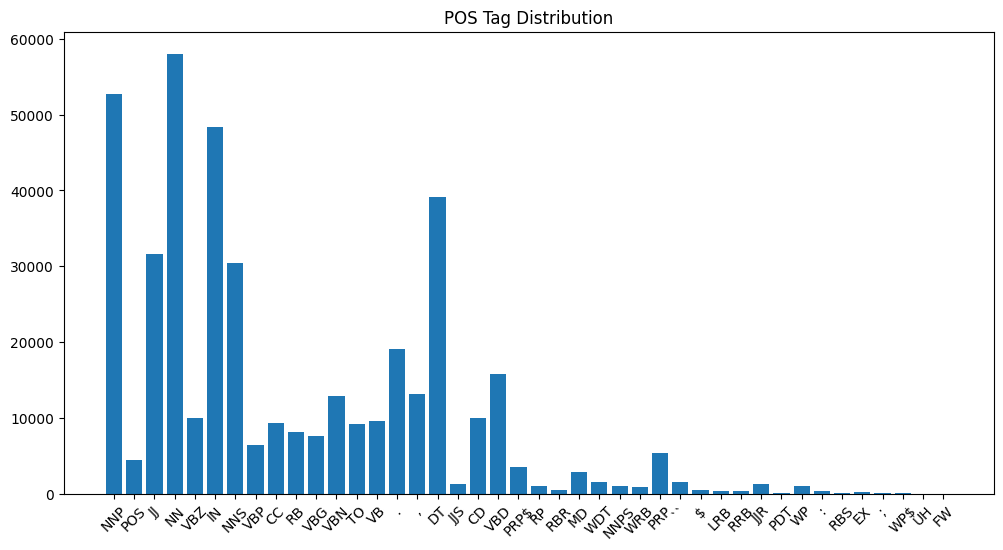

In [ ]:

plt.figure(figsize=(12,6))
plt.bar(tag_counter.keys(), tag_counter.values())
plt.xticks(rotation=45)
plt.title("POS Tag Distribution")
plt.show()


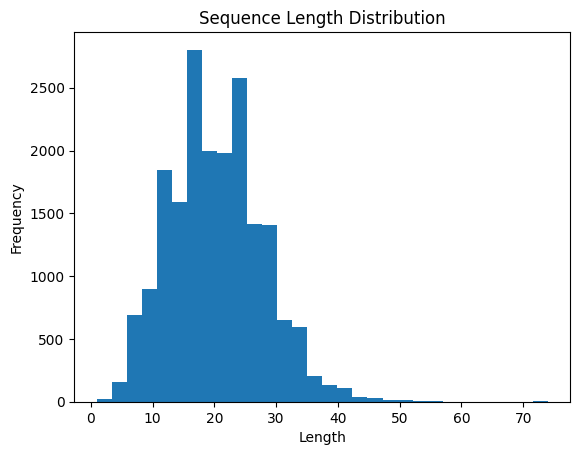

In [ ]:
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=30)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [ ]:
def parse_list(list_str):
    """Parse a string representation of a list into an actual list"""
    try:
        return ast.literal_eval(list_str)
    except (SyntaxError, ValueError):
        list_str = list_str.strip('[]').replace("'", "")
        return list_str.split(', ')


In [ ]:
train_sentences = train_df['Sentence'].tolist()
train_pos_tags = [parse_list(tags) for tags in train_df['POS'].tolist()]

test_sentences = test_df['Sentence'].tolist()
test_pos_tags = [parse_list(tags) for tags in test_df['POS'].tolist()]


print(train_sentences[0])
print(train_pos_tags[0])

Yemen 's official news agency reports Sunday that rescue efforts continue but that many people are still missing and feared to have drowned .
['NNP', 'POS', 'JJ', 'NN', 'NN', 'VBZ', 'NNP', 'IN', 'NN', 'NNS', 'VBP', 'CC', 'IN', 'JJ', 'NNS', 'VBP', 'RB', 'VBG', 'CC', 'VBN', 'TO', 'VB', 'VBN', '.']


In [ ]:
train_tokens = [sentence.split() for sentence in train_sentences]
test_tokens = [sentence.split() for sentence in test_sentences]
print(train_tokens[0])


['Yemen', "'s", 'official', 'news', 'agency', 'reports', 'Sunday', 'that', 'rescue', 'efforts', 'continue', 'but', 'that', 'many', 'people', 'are', 'still', 'missing', 'and', 'feared', 'to', 'have', 'drowned', '.']


In [ ]:
train_valid_indices = [i for i, (tokens, tags) in enumerate(zip(train_tokens, train_pos_tags)) if len(tokens) == len(tags)]
test_valid_indices = [i for i, (tokens, tags) in enumerate(zip(test_tokens, test_pos_tags)) if len(tokens) == len(tags)]

train_tokens = [train_tokens[i] for i in train_valid_indices]
train_pos_tags = [train_pos_tags[i] for i in train_valid_indices]
test_tokens = [test_tokens[i] for i in test_valid_indices]
test_pos_tags = [test_pos_tags[i] for i in test_valid_indices]

print(f"Valid training samples: {len(train_valid_indices)} / {len(train_sentences)}")
print(f"Valid testing samples: {len(test_valid_indices)} / {len(test_sentences)}")

Valid training samples: 19183 / 19184
Valid testing samples: 4796 / 4796


In [ ]:
all_tokens = [token.lower() for tokens in train_tokens for token in tokens]
all_tags = [tag for tags in train_pos_tags for tag in tags]

token_counter = Counter(all_tokens)
tag_counter = Counter(all_tags)

print(f"Vocabulary size: {len(token_counter)}")
print(f"Number of unique POS tags: {len(tag_counter)}")
print("\nTop 10 POS tags:")
for tag, count in tag_counter.most_common(10):
    print(f"{tag}: {count}")


Vocabulary size: 21006
Number of unique POS tags: 42

Top 10 POS tags:
NN: 58046
NNP: 52678
IN: 48352
DT: 39152
JJ: 31552
NNS: 30421
.: 19133
VBD: 15842
,: 13106
VBN: 12871


In [ ]:
vocab_size = 10000
word_tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
word_tokenizer.fit_on_texts([' '.join([w.lower() for w in s]) for s in train_tokens])

tag_to_idx = {tag: i for i, tag in enumerate(tag_counter.keys())}
idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}

print(f"Tag to Index Mapping: {tag_to_idx}")


Tag to Index Mapping: {'NNP': 0, 'POS': 1, 'JJ': 2, 'NN': 3, 'VBZ': 4, 'IN': 5, 'NNS': 6, 'VBP': 7, 'CC': 8, 'RB': 9, 'VBG': 10, 'VBN': 11, 'TO': 12, 'VB': 13, '.': 14, ',': 15, 'DT': 16, 'JJS': 17, 'CD': 18, 'VBD': 19, 'PRP$': 20, 'RP': 21, 'RBR': 22, 'MD': 23, 'WDT': 24, 'NNPS': 25, 'WRB': 26, 'PRP': 27, '``': 28, '$': 29, 'LRB': 30, 'RRB': 31, 'JJR': 32, 'PDT': 33, 'WP': 34, ':': 35, 'RBS': 36, 'EX': 37, ';': 38, 'WP$': 39, 'UH': 40, 'FW': 41}


In [ ]:
train_sequences = word_tokenizer.texts_to_sequences([' '.join([w.lower() for w in s]) for s in train_tokens])
test_sequences = word_tokenizer.texts_to_sequences([' '.join([w.lower() for w in s]) for s in test_tokens])

train_tag_sequences = [[tag_to_idx[tag] for tag in tags] for tags in train_pos_tags]
test_tag_sequences = [[tag_to_idx[tag] for tag in tags] for tags in test_pos_tags]

print(train_sequences[0])
print(train_tag_sequences[0])

[2743, 8, 155, 157, 144, 164, 82, 13, 1316, 322, 446, 45, 13, 200, 42, 29, 340, 762, 7, 2641, 5, 14, 5490]
[0, 1, 2, 3, 3, 4, 0, 5, 3, 6, 7, 8, 5, 2, 6, 7, 9, 10, 8, 11, 12, 13, 11, 14]


In [ ]:
max_len = min(100, max(max(len(s) for s in train_sequences), max(len(s) for s in test_sequences)))
print(f"Maximum sequence length: {max_len}")

X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = pad_sequences(train_tag_sequences, maxlen=max_len, padding='post')
y_test = pad_sequences(test_tag_sequences, maxlen=max_len, padding='post')

Maximum sequence length: 74


In [ ]:
num_classes = len(tag_to_idx)
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_train_oh shape: {y_train_oh.shape}")


X_train shape: (19183, 74)
y_train_oh shape: (19183, 74, 42)


In [ ]:
# Hyperparameters
embedding_dim = 100
hidden_units = 128
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 32
epochs = 5

In [ ]:
# Define a simplified approach using Sequential models only
def build_simple_rnn_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        SimpleRNN(hidden_units, return_sequences=True),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True  # Critical for avoiding graph execution issues
    )

    return model

def build_lstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(hidden_units, return_sequences=True),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )

    return model

def build_gru_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        GRU(hidden_units, return_sequences=True),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )

    return model

def build_bilstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(hidden_units, return_sequences=True)),
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True
    )

    return model

In [ ]:
# Simplified training and evaluation function
def train_and_evaluate_model(model, model_name):
    print(f"\n===== Training {model_name} =====")

    # Display model summary
    model.summary()

    # Train the model - without any sample weights
    history = model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

    # Make predictions
    print(f"\nMaking predictions for {model_name}...")
    y_pred = model.predict(X_test, verbose=1)

    # Post-process predictions for evaluation (ignoring padding)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(y_test_oh, axis=-1)

    # Create arrays for true and predicted labels (excluding padding)
    true_labels = []
    pred_labels = []

    for i in range(len(test_masks)):
        for j in range(max_len):
            if test_masks[i, j] == 1:  # This is a real token, not padding
                true_labels.append(y_test_classes[i, j])
                pred_labels.append(y_pred_classes[i, j])

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    f1_macro = f1_score(true_labels, pred_labels, average='macro')
    f1_weighted = f1_score(true_labels, pred_labels, average='weighted')

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} F1 Score (Macro): {f1_macro:.4f}")
    print(f"{model_name} F1 Score (Weighted): {f1_weighted:.4f}")

    # Classification report for top tags
    top_tags = [tag for tag, _ in tag_counter.most_common(10)]
    top_indices = [tag_to_idx[tag] for tag in top_tags]

    print("\nClassification Report (Top 10 tags):")
    mask_top = np.isin(true_labels, top_indices)
    if np.any(mask_top):
        true_top = true_labels[mask_top]
        pred_top = pred_labels[mask_top]

        print(classification_report(
            true_top, pred_top,
            labels=top_indices,
            target_names=top_tags
        ))

    # Return results
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'history': history.history,
        'true_labels': true_labels,
        'pred_labels': pred_labels
    }

# Hold results
results = []




Starting with Simple RNN model to test the approach...

===== Training Simple_RNN =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 323s 586ms/step - accuracy: 0.7771 - loss: 0.9258 - val_accuracy: 0.8623 - val_loss: 0.5060
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 375s 585ms/step - accuracy: 0.8653 - loss: 0.4776 - val_accuracy: 0.8747 - val_loss: 0.4262
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 324s 590ms/step - accuracy: 0.8779 - loss: 0.4046 - val_accuracy: 0.8790 - val_loss: 0.4046
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 322s 590ms/step - accuracy: 0.8864 - loss: 0.3676 - val_accuracy: 0.8820 - val_loss: 0.3931
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 322s 589ms/step - accuracy: 0.8950 - loss: 0.3368 - val_accuracy: 0.8837 - val_loss: 0.3940


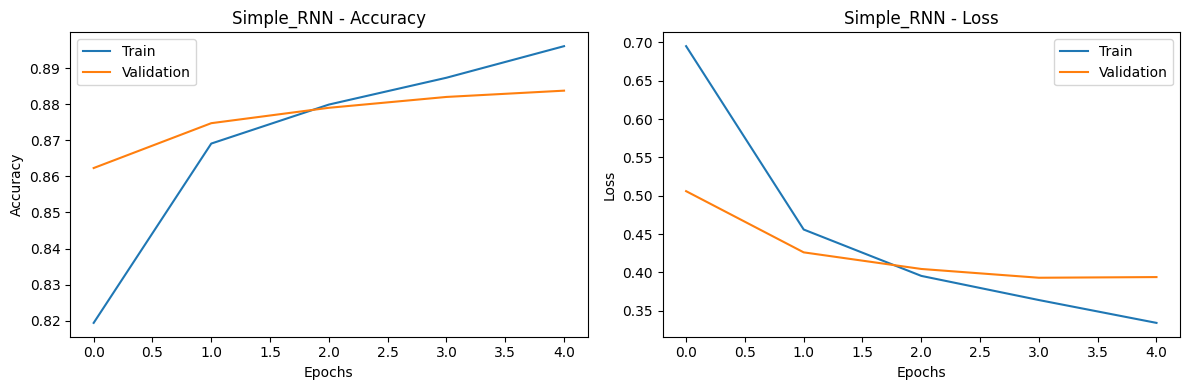


Making predictions for Simple_RNN...
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step
Simple_RNN Accuracy: 0.6229
Simple_RNN F1 Score (Macro): 0.4426
Simple_RNN F1 Score (Weighted): 0.6151

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.66      0.64      0.65     13757
         NNP       0.70      0.73      0.72     12846
          IN       0.68      0.65      0.66     12028
          DT       0.70      0.73      0.72      9783
          JJ       0.71      0.55      0.62      7586
         NNS       0.73      0.62      0.67      7117
           .       0.21      0.01      0.02       767
         VBD       0.66      0.66      0.66      3877
           ,       0.64      0.25      0.36      3192
         VBN       0.76      0.60      0.67      3273

   micro avg       0.69      0.63      0.66     74226
   macro avg       0.64      0.54      0.57     74226
weighted avg       0.69      0.63      0.65     74226



In [ ]:
# Simple RNN - let's try just one model first to make sure it works
print("\nStarting with Simple RNN model to test the approach...")
simple_rnn_model = build_simple_rnn_model()
simple_rnn_results = train_and_evaluate_model(simple_rnn_model, 'Simple_RNN')
results.append(simple_rnn_results)



Trying LSTM model...

===== Training LSTM =====


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 152s 281ms/step - accuracy: 0.7618 - loss: 1.0027 - val_accuracy: 0.8569 - val_loss: 0.5227
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 202s 281ms/step - accuracy: 0.8621 - loss: 0.4887 - val_accuracy: 0.8773 - val_loss: 0.4202
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 203s 284ms/step - accuracy: 0.8798 - loss: 0.3955 - val_accuracy: 0.8848 - val_loss: 0.3846
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 153s 283ms/step - accuracy: 0.8919 - loss: 0.3441 - val_accuracy: 0.8889 - val_loss: 0.3850
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 203s 285ms/step - accuracy: 0.9000 - loss: 0.3147 - val_accuracy: 0.8906 - val_loss: 0.3651


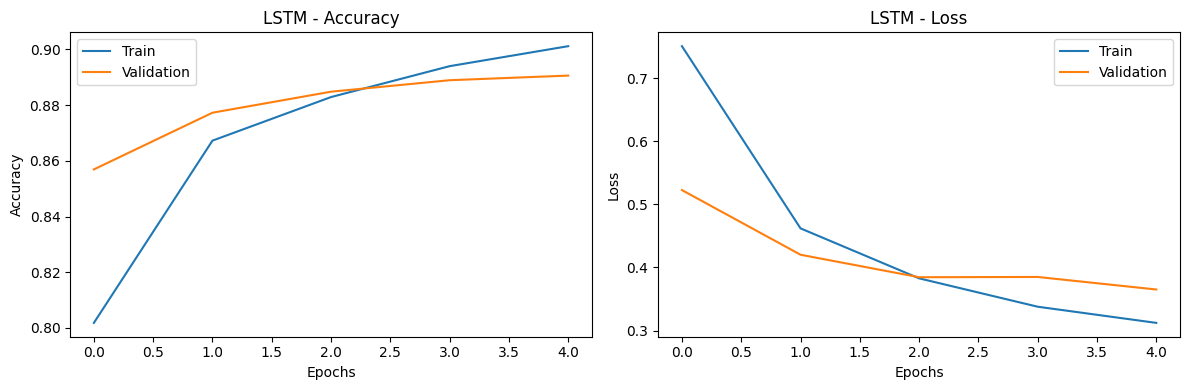


Making predictions for LSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step
LSTM Accuracy: 0.6438
LSTM F1 Score (Macro): 0.4554
LSTM F1 Score (Weighted): 0.6361

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.67      0.68      0.68     13757
         NNP       0.70      0.75      0.72     12846
          IN       0.70      0.66      0.68     12028
          DT       0.74      0.73      0.74      9783
          JJ       0.71      0.59      0.65      7586
         NNS       0.73      0.65      0.69      7117
           .       0.21      0.03      0.05       767
         VBD       0.75      0.65      0.69      3877
           ,       0.70      0.24      0.36      3192
         VBN       0.77      0.65      0.71      3273

   micro avg       0.71      0.65      0.68     74226
   macro avg       0.67      0.56      0.60     74226
weighted avg       0.71      0.65      0.67     74226



In [ ]:
# If the Simple RNN works, run the others
print("\nTrying LSTM model...")
lstm_model = build_lstm_model()
lstm_results = train_and_evaluate_model(lstm_model, 'LSTM')
results.append(lstm_results)


Trying GRU model...

===== Training GRU =====


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 151s 280ms/step - accuracy: 0.7818 - loss: 0.9252 - val_accuracy: 0.8656 - val_loss: 0.4748
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 206s 288ms/step - accuracy: 0.8691 - loss: 0.4471 - val_accuracy: 0.8804 - val_loss: 0.3949
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 200s 285ms/step - accuracy: 0.8826 - loss: 0.3711 - val_accuracy: 0.8863 - val_loss: 0.3648
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 206s 292ms/step - accuracy: 0.8941 - loss: 0.3272 - val_accuracy: 0.8874 - val_loss: 0.3560
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 153s 282ms/step - accuracy: 0.9036 - loss: 0.2971 - val_accuracy: 0.8923 - val_loss: 0.3579


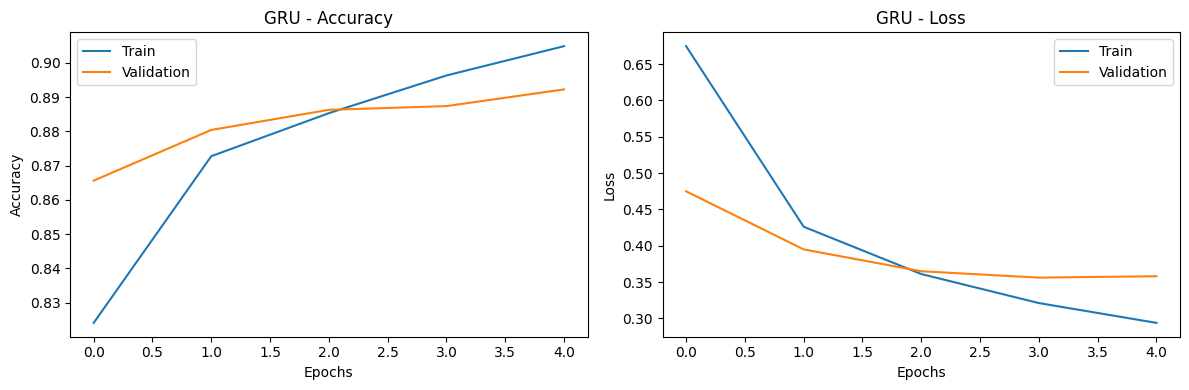


Making predictions for GRU...
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step
GRU Accuracy: 0.6472
GRU F1 Score (Macro): 0.4623
GRU F1 Score (Weighted): 0.6402

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.70      0.65      0.68     13757
         NNP       0.68      0.77      0.72     12846
          IN       0.68      0.68      0.68     12028
          DT       0.76      0.72      0.74      9783
          JJ       0.70      0.59      0.64      7586
         NNS       0.77      0.64      0.70      7117
           .       0.22      0.03      0.05       767
         VBD       0.75      0.65      0.70      3877
           ,       0.66      0.27      0.39      3192
         VBN       0.77      0.67      0.71      3273

   micro avg       0.71      0.66      0.68     74226
   macro avg       0.67      0.57      0.60     74226
weighted avg       0.71      0.66      0.68     74226



In [ ]:
print("\nTrying GRU model...")
gru_model = build_gru_model()
gru_results = train_and_evaluate_model(gru_model, 'GRU')
results.append(gru_results)


Trying BiLSTM model...

===== Training BiLSTM =====


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 172s 318ms/step - accuracy: 0.7738 - loss: 0.8947 - val_accuracy: 0.8660 - val_loss: 0.4657
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 200s 315ms/step - accuracy: 0.8688 - loss: 0.4404 - val_accuracy: 0.8841 - val_loss: 0.3745
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 204s 320ms/step - accuracy: 0.8898 - loss: 0.3467 - val_accuracy: 0.8924 - val_loss: 0.3520
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 201s 318ms/step - accuracy: 0.9034 - loss: 0.2982 - val_accuracy: 0.8975 - val_loss: 0.3384
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 204s 323ms/step - accuracy: 0.9132 - loss: 0.2688 - val_accuracy: 0.8986 - val_loss: 0.3425


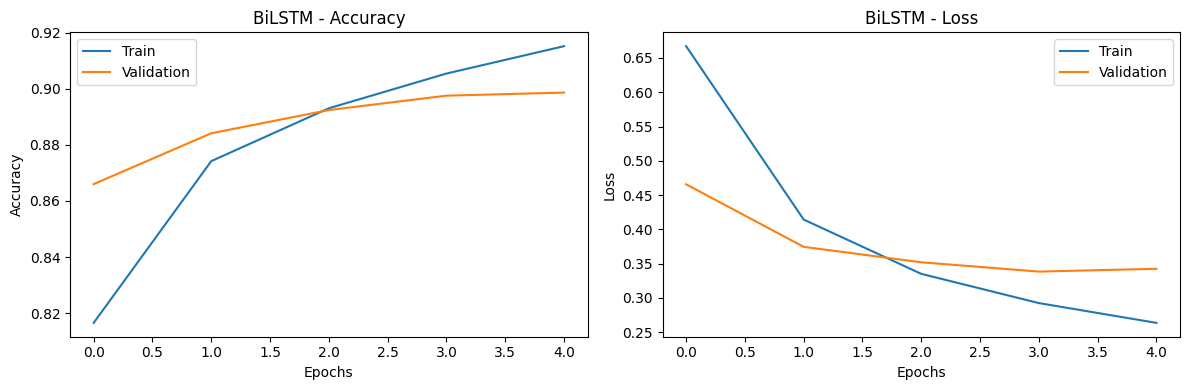


Making predictions for BiLSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step
BiLSTM Accuracy: 0.6797
BiLSTM F1 Score (Macro): 0.4973
BiLSTM F1 Score (Weighted): 0.6745

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.72      0.70      0.71     13757
         NNP       0.78      0.75      0.76     12846
          IN       0.73      0.72      0.73     12028
          DT       0.77      0.76      0.77      9783
          JJ       0.73      0.66      0.69      7586
         NNS       0.76      0.70      0.73      7117
           .       0.48      0.56      0.52       767
         VBD       0.77      0.66      0.71      3877
           ,       0.64      0.25      0.37      3192
         VBN       0.79      0.68      0.73      3273

   micro avg       0.74      0.69      0.72     74226
   macro avg       0.72      0.64      0.67     74226
weighted avg       0.74      0.69      0.71     74226



In [ ]:
print("\nTrying BiLSTM model...")
bilstm_model = build_bilstm_model()
bilstm_results = train_and_evaluate_model(bilstm_model, 'BiLSTM')
results.append(bilstm_results)

model for hypermeters
# Hyperparameters
embedding_dim = 100
hidden_units = 128
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 32
epochs = 5  


Model Performance Comparison:
     Model  Accuracy  F1 Macro  F1 Weighted
Simple_RNN  0.622870  0.442550     0.615135
      LSTM  0.643804  0.455395     0.636060
       GRU  0.647242  0.462332     0.640178
    BiLSTM  0.679694  0.497308     0.674541


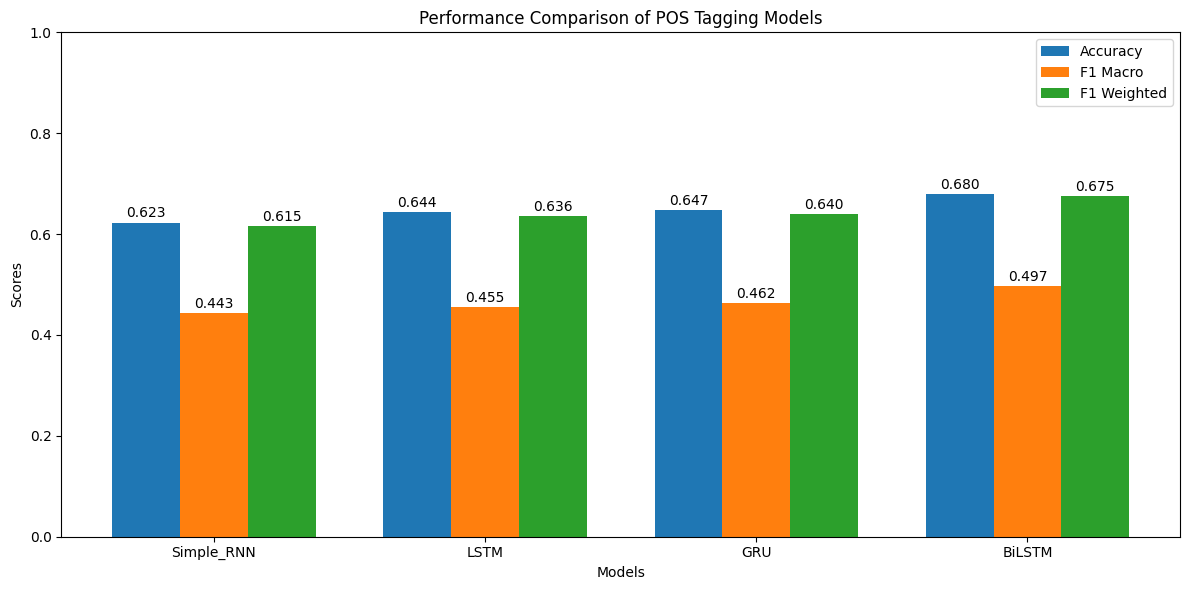


Best model: BiLSTM with F1 weighted score of 0.6745


In [ ]:
# Compare models
def compare_models(results):
    """Compare the performance of different models"""
    model_names = [result['model_name'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    f1_macro_scores = [result['f1_macro'] for result in results]
    f1_weighted_scores = [result['f1_weighted'] for result in results]

    # Create comparison table
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'F1 Macro': f1_macro_scores,
        'F1 Weighted': f1_weighted_scores
    })

    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # Create bar chart
    x = np.arange(len(model_names))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, f1_macro_scores, width, label='F1 Macro')
    plt.bar(x + width, f1_weighted_scores, width, label='F1 Weighted')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Comparison of POS Tagging Models')
    plt.xticks(x, model_names)
    plt.legend()
    plt.ylim(0, 1)

    # Add value labels
    for i, v in enumerate(accuracies):
        plt.text(i - width, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_macro_scores):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_weighted_scores):
        plt.text(i + width, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Compare the models
compare_models(results)

# Identify the best model
best_model_idx = np.argmax([result['f1_weighted'] for result in results])
best_model = results[best_model_idx]['model_name']
best_score = results[best_model_idx]['f1_weighted']
print(f"\nBest model: {best_model} with F1 weighted score of {best_score:.4f}")

In [ ]:
#  new Hyperparameters
embedding_dim = 100
hidden_units = 64
dropout_rate = 0.5
learning_rate = 0.0001
batch_size = 32
epochs = 10


Starting with Simple RNN model to test the approach...

===== Training Simple_RNN =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 334s 617ms/step - accuracy: 0.7623 - loss: 1.0387 - val_accuracy: 0.8608 - val_loss: 0.5303
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 328s 608ms/step - accuracy: 0.8623 - loss: 0.5068 - val_accuracy: 0.8714 - val_loss: 0.4515
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 382s 609ms/step - accuracy: 0.8730 - loss: 0.4336 - val_accuracy: 0.8759 - val_loss: 0.4255
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 383s 611ms/step - accuracy: 0.8809 - loss: 0.3930 - val_accuracy: 0.8792 - val_loss: 0.4256
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 383s 614ms/step - accuracy: 0.8875 - loss: 0.3674 - val_accuracy: 0.8799 - val_loss: 0.4210
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 377s 606ms/step - accuracy: 0.8932 - loss: 0.3488 - val_accuracy: 0.8789 - val_loss: 0.4109
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 381s 605ms/step - accuracy: 0.8987 - loss: 0.3309 - val_accuracy: 0.8784 - val_loss: 0.4138
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 327s 606ms/step - accuracy: 0.9054 -

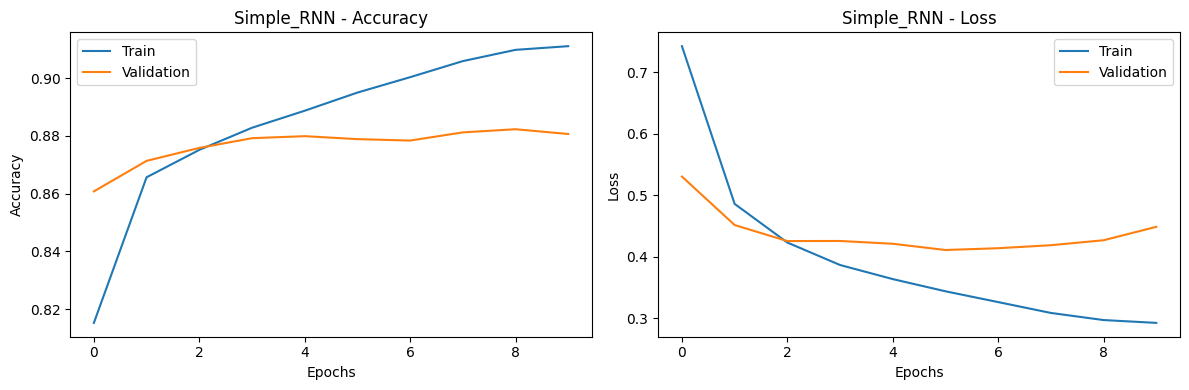


Making predictions for Simple_RNN...
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step
Simple_RNN Accuracy: 0.6123
Simple_RNN F1 Score (Macro): 0.4314
Simple_RNN F1 Score (Weighted): 0.6063

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.64      0.65      0.64     13757
         NNP       0.73      0.69      0.71     12846
          IN       0.66      0.64      0.65     12028
          DT       0.71      0.70      0.71      9783
          JJ       0.65      0.58      0.61      7586
         NNS       0.70      0.63      0.66      7117
           .       0.17      0.02      0.04       767
         VBD       0.71      0.61      0.65      3877
           ,       0.53      0.29      0.37      3192
         VBN       0.73      0.61      0.66      3273

   micro avg       0.68      0.63      0.65     74226
   macro avg       0.62      0.54      0.57     74226
weighted avg       0.67      0.63      0.65     74226



In [ ]:
# Simple RNN - let's try just one model first to make sure it works
print("\nStarting with Simple RNN model to test the approach...")
simple_rnn_model = build_simple_rnn_model()
simple_rnn_results = train_and_evaluate_model(simple_rnn_model, 'Simple_RNN')
results.append(simple_rnn_results)




Trying LSTM model...

===== Training LSTM =====


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 466s 863ms/step - accuracy: 0.7638 - loss: 1.0393 - val_accuracy: 0.8540 - val_loss: 0.5440
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 446s 825ms/step - accuracy: 0.8603 - loss: 0.5112 - val_accuracy: 0.8740 - val_loss: 0.4478
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 460s 852ms/step - accuracy: 0.8757 - loss: 0.4289 - val_accuracy: 0.8773 - val_loss: 0.4194
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 485s 820ms/step - accuracy: 0.8850 - loss: 0.3827 - val_accuracy: 0.8829 - val_loss: 0.4021
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 503s 823ms/step - accuracy: 0.8923 - loss: 0.3503 - val_accuracy: 0.8829 - val_loss: 0.3859
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 497s 815ms/step - accuracy: 0.8974 - loss: 0.3305 - val_accuracy: 0.8825 - val_loss: 0.3856
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 463s 854ms/step - accuracy: 0.9022 - loss: 0.3130 - val_accuracy: 0.8882 - val_loss: 0.3908
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 482s 816ms/step - accuracy: 0.9064 -

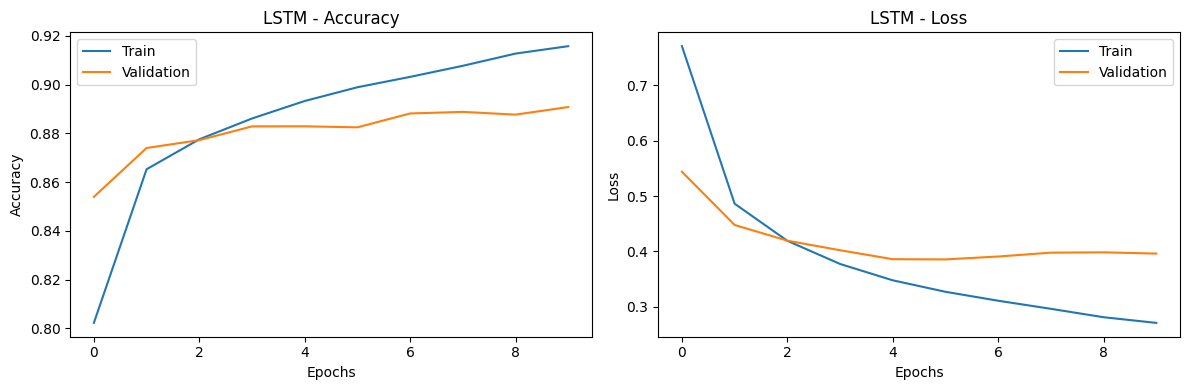


Making predictions for LSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step
LSTM Accuracy: 0.6430
LSTM F1 Score (Macro): 0.4584
LSTM F1 Score (Weighted): 0.6371

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.68      0.66      0.67     13757
         NNP       0.72      0.73      0.73     12846
          IN       0.68      0.68      0.68     12028
          DT       0.75      0.73      0.74      9783
          JJ       0.70      0.59      0.64      7586
         NNS       0.73      0.67      0.70      7117
           .       0.21      0.08      0.12       767
         VBD       0.74      0.64      0.69      3877
           ,       0.59      0.27      0.37      3192
         VBN       0.78      0.65      0.71      3273

   micro avg       0.71      0.65      0.68     74226
   macro avg       0.66      0.57      0.60     74226
weighted avg       0.70      0.65      0.67     74226



In [ ]:
# If the Simple RNN works, run the others
print("\nTrying LSTM model...")
lstm_model = build_lstm_model()
lstm_results = train_and_evaluate_model(lstm_model, 'LSTM')
results.append(lstm_results)


Trying GRU model...

===== Training GRU =====


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 660s 1s/step - accuracy: 0.7797 - loss: 0.9660 - val_accuracy: 0.8624 - val_loss: 0.5028
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - accuracy: 0.8645 - loss: 0.4758 - val_accuracy: 0.8752 - val_loss: 0.4165
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.8771 - loss: 0.3996 - val_accuracy: 0.8804 - val_loss: 0.3953
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.8857 - loss: 0.3602 - val_accuracy: 0.8847 - val_loss: 0.3826
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.8940 - loss: 0.3299 - val_accuracy: 0.8885 - val_loss: 0.3767
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.9016 - loss: 0.3064 - val_accuracy: 0.8878 - val_loss: 0.3664
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 683s 1s/step - accuracy: 0.9077 - loss: 0.2881 - val_accuracy: 0.8914 - val_loss: 0.3713
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.9133 - loss: 0.2710 - val_accu

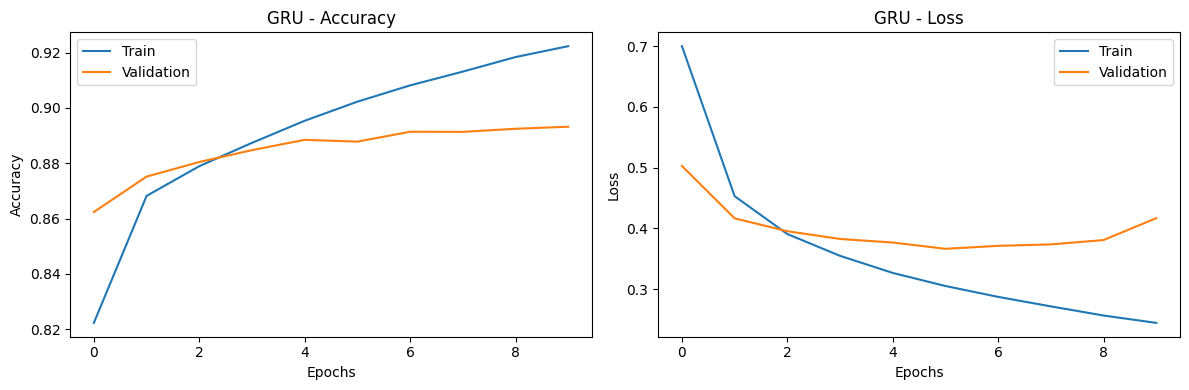


Making predictions for GRU...
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 523ms/step
GRU Accuracy: 0.6498
GRU F1 Score (Macro): 0.4716
GRU F1 Score (Weighted): 0.6438

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.69      0.68      0.68     13757
         NNP       0.72      0.75      0.73     12846
          IN       0.69      0.68      0.68     12028
          DT       0.76      0.72      0.74      9783
          JJ       0.71      0.61      0.65      7586
         NNS       0.73      0.67      0.70      7117
           .       0.18      0.09      0.12       767
         VBD       0.77      0.62      0.69      3877
           ,       0.65      0.26      0.37      3192
         VBN       0.74      0.68      0.71      3273

   micro avg       0.71      0.66      0.69     74226
   macro avg       0.66      0.58      0.61     74226
weighted avg       0.71      0.66      0.68     74226



In [ ]:
print("\nTrying GRU model...")
gru_model = build_gru_model()
gru_results = train_and_evaluate_model(gru_model, 'GRU')
results.append(gru_results)


Trying BiLSTM model...

===== Training BiLSTM =====


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - accuracy: 0.7711 - loss: 0.9451 - val_accuracy: 0.8629 - val_loss: 0.4874
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.8649 - loss: 0.4652 - val_accuracy: 0.8776 - val_loss: 0.4051
Epoch 3/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 884s 2s/step - accuracy: 0.8809 - loss: 0.3789 - val_accuracy: 0.8872 - val_loss: 0.3728
Epoch 4/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 866s 2s/step - accuracy: 0.8950 - loss: 0.3258 - val_accuracy: 0.8908 - val_loss: 0.3548
Epoch 5/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.9052 - loss: 0.2933 - val_accuracy: 0.8897 - val_loss: 0.3537
Epoch 6/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 903s 2s/step - accuracy: 0.9111 - loss: 0.2750 - val_accuracy: 0.8948 - val_loss: 0.3570
Epoch 7/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.9197 - loss: 0.2501 - val_accuracy: 0.8962 - val_loss: 0.3594
Epoch 8/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 899s 2s/step - accuracy: 0.9280 - loss: 0.2280 - val_accu

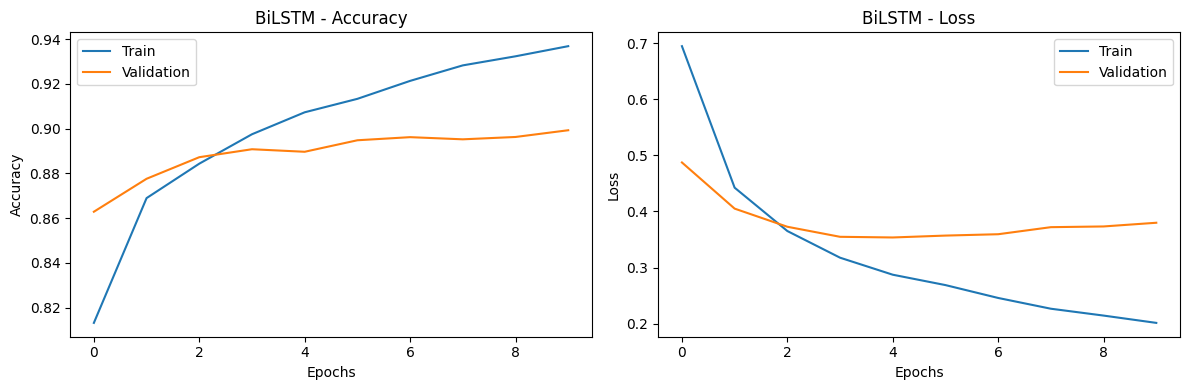


Making predictions for BiLSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 96s 642ms/step
BiLSTM Accuracy: 0.6730
BiLSTM F1 Score (Macro): 0.4938
BiLSTM F1 Score (Weighted): 0.6693

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.71      0.70      0.70     13757
         NNP       0.78      0.73      0.76     12846
          IN       0.72      0.71      0.71     12028
          DT       0.79      0.74      0.76      9783
          JJ       0.73      0.65      0.69      7586
         NNS       0.76      0.70      0.73      7117
           .       0.47      0.54      0.50       767
         VBD       0.75      0.67      0.71      3877
           ,       0.54      0.29      0.38      3192
         VBN       0.78      0.67      0.72      3273

   micro avg       0.74      0.69      0.71     74226
   macro avg       0.70      0.64      0.67     74226
weighted avg       0.74      0.69      0.71     74226



In [ ]:
print("\nTrying BiLSTM model...")
bilstm_model = build_bilstm_model()
bilstm_results = train_and_evaluate_model(bilstm_model, 'BiLSTM')
results.append(bilstm_results)


Model Performance Comparison:
     Model  Accuracy  F1 Macro  F1 Weighted
Simple_RNN  0.612250  0.431380     0.606336
      LSTM  0.643029  0.458356     0.637084
       GRU  0.649813  0.471647     0.643816
    BiLSTM  0.673033  0.493804     0.669304


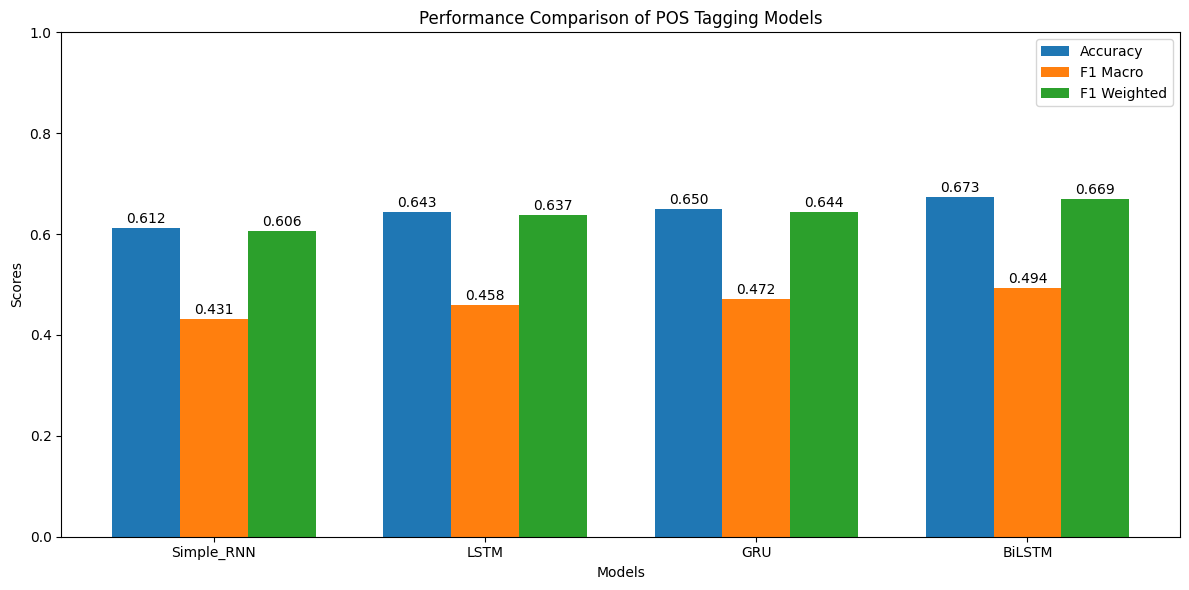


Best model: BiLSTM with F1 weighted score of 0.6693


In [ ]:
# Compare models
def compare_models(results):
    """Compare the performance of different models"""
    model_names = [result['model_name'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    f1_macro_scores = [result['f1_macro'] for result in results]
    f1_weighted_scores = [result['f1_weighted'] for result in results]

    # Create comparison table
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'F1 Macro': f1_macro_scores,
        'F1 Weighted': f1_weighted_scores
    })

    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # Create bar chart
    x = np.arange(len(model_names))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, f1_macro_scores, width, label='F1 Macro')
    plt.bar(x + width, f1_weighted_scores, width, label='F1 Weighted')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Comparison of POS Tagging Models')
    plt.xticks(x, model_names)
    plt.legend()
    plt.ylim(0, 1)

    # Add value labels
    for i, v in enumerate(accuracies):
        plt.text(i - width, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_macro_scores):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_weighted_scores):
        plt.text(i + width, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Compare the models
compare_models(results)

# Identify the best model
best_model_idx = np.argmax([result['f1_weighted'] for result in results])
best_model = results[best_model_idx]['model_name']
best_score = results[best_model_idx]['f1_weighted']
print(f"\nBest model: {best_model} with F1 weighted score of {best_score:.4f}")

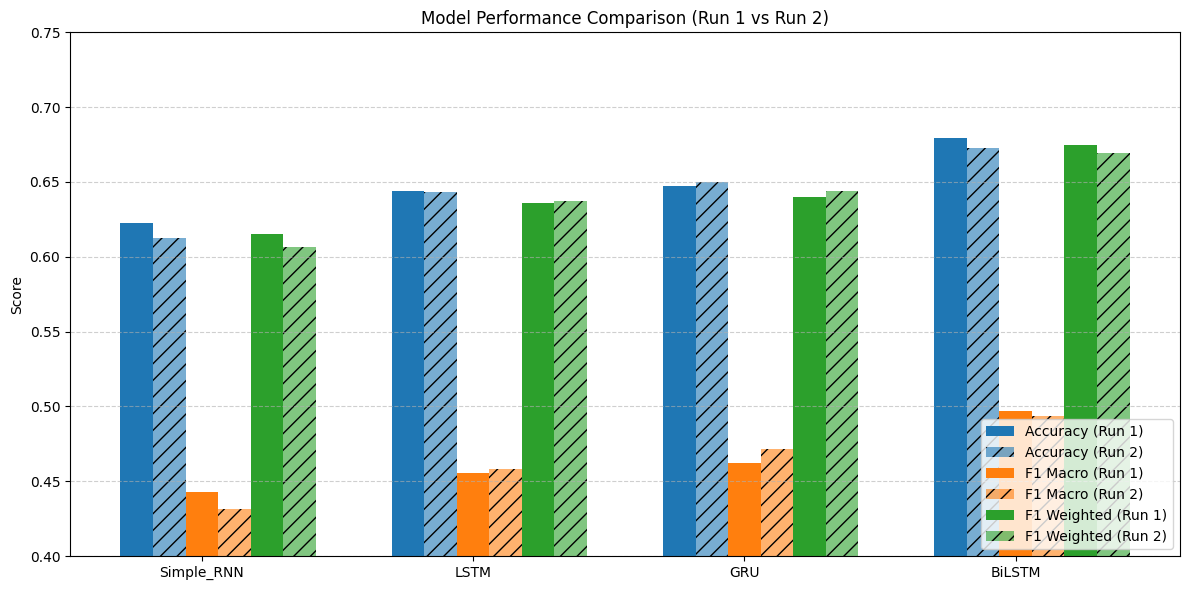

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
models = ['Simple_RNN', 'LSTM', 'GRU', 'BiLSTM']
metrics = ['Accuracy', 'F1 Macro', 'F1 Weighted']

# Metrics for Run 1
run1 = [
    [0.622870, 0.643804, 0.647242, 0.679694],     # Accuracy
    [0.442550, 0.455395, 0.462332, 0.497308],     # F1 Macro
    [0.615135, 0.636060, 0.640178, 0.674541]      # F1 Weighted
]

# Metrics for Run 2
run2 = [
    [0.612250, 0.643029, 0.649813, 0.673033],     # Accuracy
    [0.431380, 0.458356, 0.471647, 0.493804],     # F1 Macro
    [0.606336, 0.637084, 0.643816, 0.669304]      # F1 Weighted
]

# Settings
x = np.arange(len(models))  # Model positions
width = 0.12  # Width of individual bars

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through metrics and plot Run 1 and Run 2
for i in range(len(metrics)):
    offset = i * 2 * width  # space each metric group
    ax.bar(x + offset - width, run1[i], width, label=f'{metrics[i]} (Run 1)', color=f'C{i}')
    ax.bar(x + offset, run2[i], width, label=f'{metrics[i]} (Run 2)', color=f'C{i}', alpha=0.6, hatch='//')

# Axis setup
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_ylim(0.4, 0.75)
ax.set_title('Model Performance Comparison (Run 1 vs Run 2)')
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
embedding_dim = 100
hidden_units = 128
dropout_rate = 0.4
learning_rate = 0.0005
batch_size = 32
epochs = 5


Starting with Simple RNN model to test the approach...

===== Training Simple_RNN =====


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 365s 676ms/step - accuracy: 0.7793 - loss: 0.9164 - val_accuracy: 0.8641 - val_loss: 0.4997
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 384s 680ms/step - accuracy: 0.8660 - loss: 0.4717 - val_accuracy: 0.8740 - val_loss: 0.4234
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 377s 672ms/step - accuracy: 0.8779 - loss: 0.4013 - val_accuracy: 0.8801 - val_loss: 0.4009
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 365s 676ms/step - accuracy: 0.8878 - loss: 0.3625 - val_accuracy: 0.8843 - val_loss: 0.3976
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 383s 677ms/step - accuracy: 0.8953 - loss: 0.3356 - val_accuracy: 0.8855 - val_loss: 0.4254


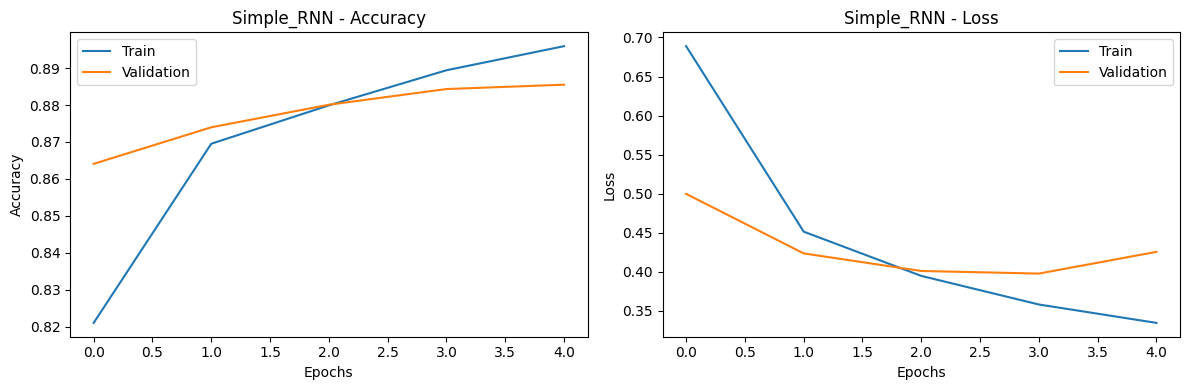


Making predictions for Simple_RNN...
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step
Simple_RNN Accuracy: 0.6235
Simple_RNN F1 Score (Macro): 0.4442
Simple_RNN F1 Score (Weighted): 0.6157

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.65      0.66      0.65     13757
         NNP       0.68      0.73      0.71     12846
          IN       0.66      0.66      0.66     12028
          DT       0.75      0.70      0.73      9783
          JJ       0.72      0.56      0.63      7586
         NNS       0.71      0.64      0.67      7117
           .       0.22      0.01      0.03       767
         VBD       0.71      0.60      0.65      3877
           ,       0.63      0.24      0.35      3192
         VBN       0.73      0.64      0.68      3273

   micro avg       0.69      0.64      0.66     74226
   macro avg       0.65      0.55      0.58     74226
weighted avg       0.68      0.64      0.65     74226



In [ ]:
# Simple RNN - let's try just one model first to make sure it works
print("\nStarting with Simple RNN model to test the approach...")
simple_rnn_model = build_simple_rnn_model()
simple_rnn_results = train_and_evaluate_model(simple_rnn_model, 'Simple_RNN')
true_labels = simple_rnn_results['true_labels']
pred_labels = simple_rnn_results['pred_labels']
results.append(simple_rnn_results)

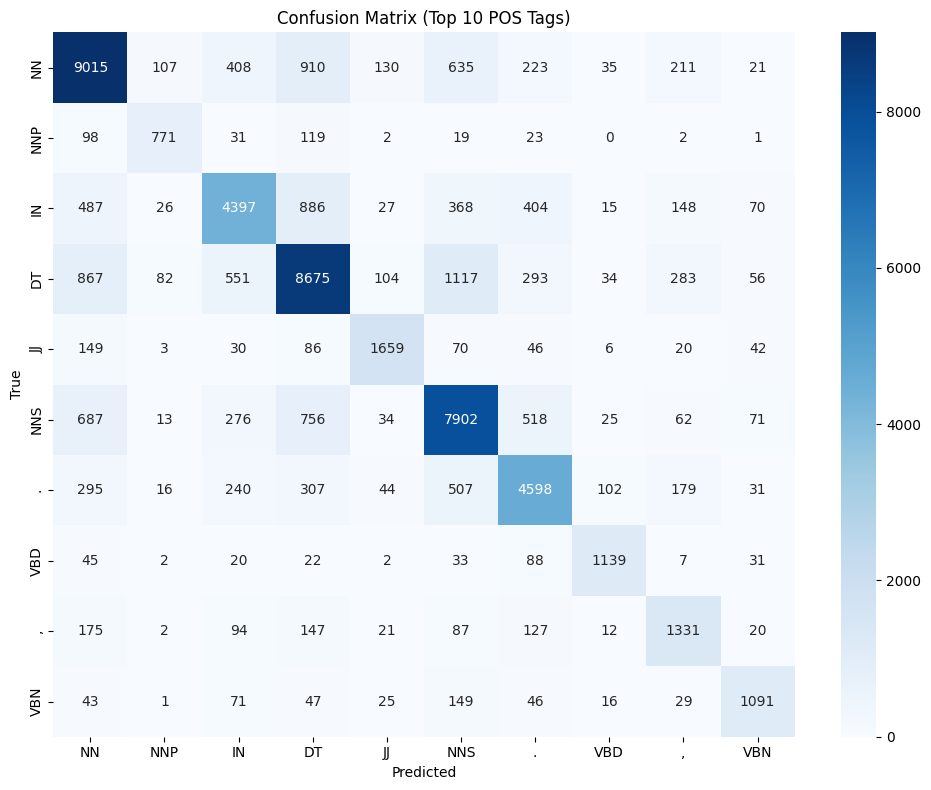

In [ ]:
# Top tag setup
idx_to_tag = {0: 'NN', 1: 'NNP', 2: 'IN', 3: 'DT', 4: 'JJ',
              5: 'NNS', 6: '.', 7: 'VBD', 8: ',', 9: 'VBN'}

top_indices = list(idx_to_tag.keys())
top_tags = [idx_to_tag[i] for i in top_indices]

# Filter for top tags only
mask_top = np.isin(true_labels, top_indices)
true_top = true_labels[mask_top]
pred_top = pred_labels[mask_top]

# Confusion matrix
cm = confusion_matrix(true_top, pred_top, labels=top_indices)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=top_tags,
            yticklabels=top_tags,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 POS Tags)')
plt.tight_layout()
plt.show()



Trying LSTM model...

===== Training LSTM =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 591s 1s/step - accuracy: 0.7606 - loss: 1.0056 - val_accuracy: 0.8541 - val_loss: 0.5320
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.8609 - loss: 0.4963 - val_accuracy: 0.8760 - val_loss: 0.4200
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.8798 - loss: 0.3975 - val_accuracy: 0.8854 - val_loss: 0.3814
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.8915 - loss: 0.3465 - val_accuracy: 0.8898 - val_loss: 0.3797
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.8996 - loss: 0.3167 - val_accuracy: 0.8909 - val_loss: 0.3646


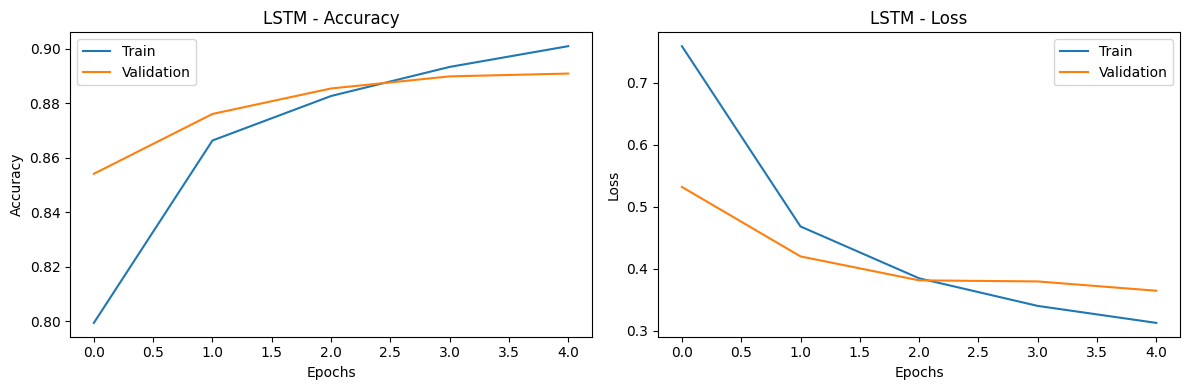


Making predictions for LSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 442ms/step
LSTM Accuracy: 0.6432
LSTM F1 Score (Macro): 0.4525
LSTM F1 Score (Weighted): 0.6358

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.68      0.67      0.67     13757
         NNP       0.71      0.75      0.73     12846
          IN       0.68      0.67      0.68     12028
          DT       0.77      0.72      0.74      9783
          JJ       0.69      0.59      0.64      7586
         NNS       0.75      0.65      0.69      7117
           .       0.13      0.02      0.03       767
         VBD       0.71      0.67      0.69      3877
           ,       0.66      0.27      0.38      3192
         VBN       0.79      0.63      0.70      3273

   micro avg       0.71      0.66      0.68     74226
   macro avg       0.66      0.56      0.60     74226
weighted avg       0.70      0.66      0.67     74226



In [ ]:
# If the Simple RNN works, run the others
print("\nTrying LSTM model...")
lstm_model = build_lstm_model()
lstm_results = train_and_evaluate_model(lstm_model, 'LSTM')
true_labels = lstm_results['true_labels']
pred_labels = lstm_results['pred_labels']
results.append(lstm_results)

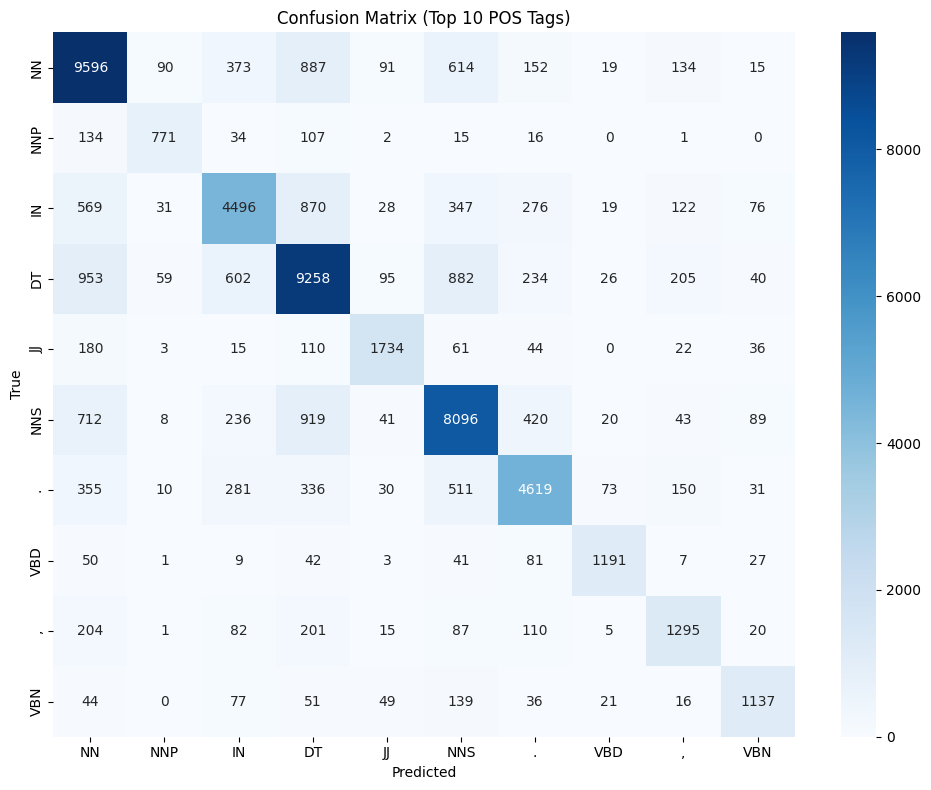

In [ ]:
# Top tag setup
idx_to_tag = {0: 'NN', 1: 'NNP', 2: 'IN', 3: 'DT', 4: 'JJ',
              5: 'NNS', 6: '.', 7: 'VBD', 8: ',', 9: 'VBN'}

top_indices = list(idx_to_tag.keys())
top_tags = [idx_to_tag[i] for i in top_indices]

# Filter for top tags only
mask_top = np.isin(true_labels, top_indices)
true_top = true_labels[mask_top]
pred_top = pred_labels[mask_top]

# Confusion matrix
cm = confusion_matrix(true_top, pred_top, labels=top_indices)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=top_tags,
            yticklabels=top_tags,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 POS Tags)')
plt.tight_layout()
plt.show()



Trying GRU model...

===== Training GRU =====


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.7810 - loss: 0.9236 - val_accuracy: 0.8663 - val_loss: 0.4705
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 731s 1s/step - accuracy: 0.8697 - loss: 0.4442 - val_accuracy: 0.8808 - val_loss: 0.3943
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.8835 - loss: 0.3702 - val_accuracy: 0.8880 - val_loss: 0.3638
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 795s 1s/step - accuracy: 0.8952 - loss: 0.3260 - val_accuracy: 0.8899 - val_loss: 0.3564
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.9054 - loss: 0.2946 - val_accuracy: 0.8934 - val_loss: 0.3594


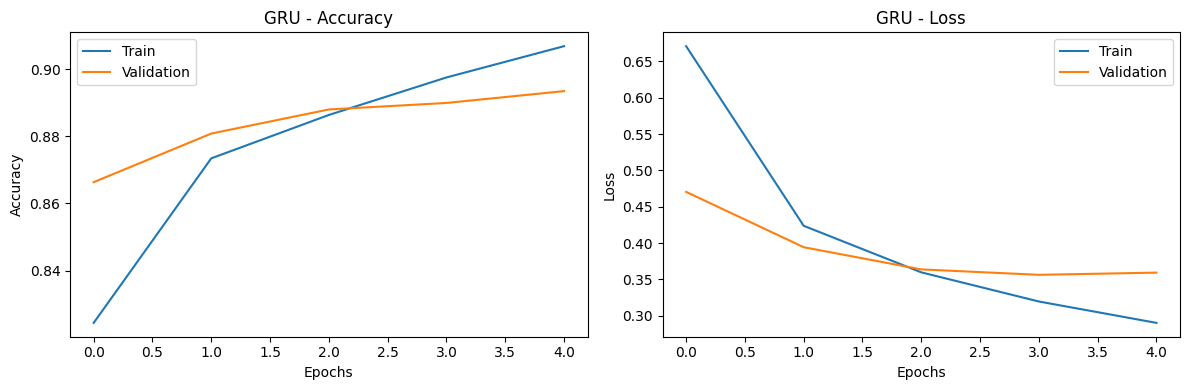


Making predictions for GRU...
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 568ms/step
GRU Accuracy: 0.6544
GRU F1 Score (Macro): 0.4736
GRU F1 Score (Weighted): 0.6482

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.68      0.69      0.68     13757
         NNP       0.71      0.75      0.73     12846
          IN       0.70      0.68      0.69     12028
          DT       0.77      0.73      0.75      9783
          JJ       0.72      0.59      0.65      7586
         NNS       0.77      0.66      0.71      7117
           .       0.19      0.08      0.12       767
         VBD       0.75      0.65      0.70      3877
           ,       0.68      0.27      0.39      3192
         VBN       0.79      0.66      0.72      3273

   micro avg       0.72      0.67      0.69     74226
   macro avg       0.67      0.58      0.61     74226
weighted avg       0.71      0.67      0.68     74226



In [ ]:
print("\nTrying GRU model...")
gru_model = build_gru_model()
gru_results = train_and_evaluate_model(gru_model, 'GRU')
true_labels = gru_results['true_labels']
pred_labels = gru_results['pred_labels']
results.append(gru_results)

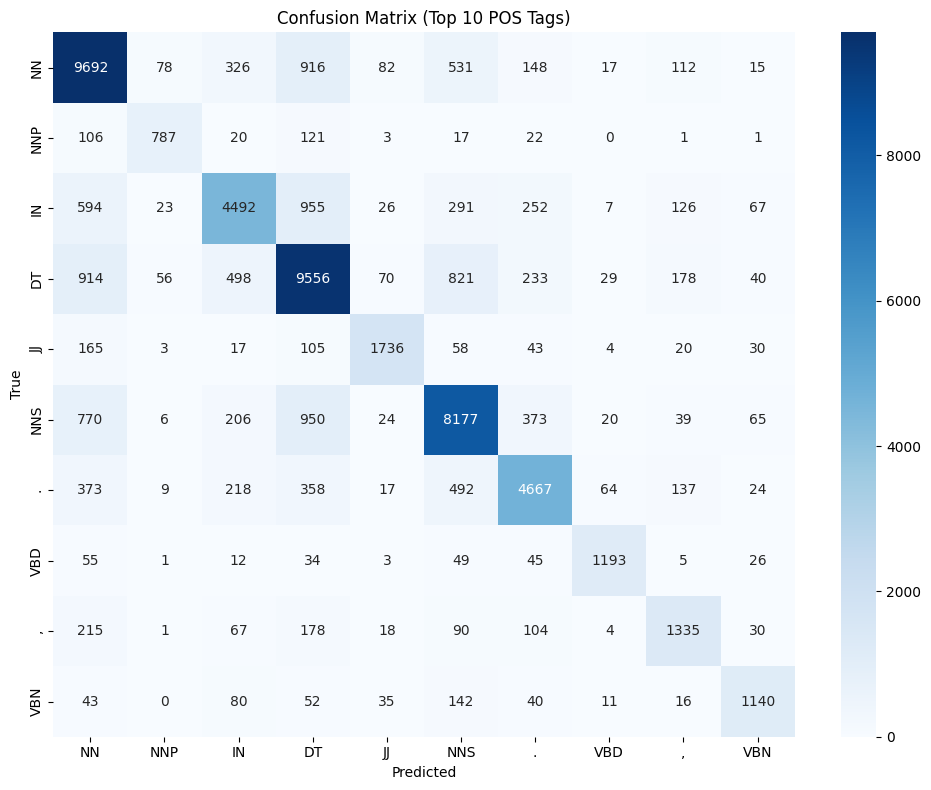

In [ ]:
# Top tag setup
idx_to_tag = {0: 'NN', 1: 'NNP', 2: 'IN', 3: 'DT', 4: 'JJ',
              5: 'NNS', 6: '.', 7: 'VBD', 8: ',', 9: 'VBN'}

top_indices = list(idx_to_tag.keys())
top_tags = [idx_to_tag[i] for i in top_indices]

# Filter for top tags only
mask_top = np.isin(true_labels, top_indices)
true_top = true_labels[mask_top]
pred_top = pred_labels[mask_top]

# Confusion matrix
cm = confusion_matrix(true_top, pred_top, labels=top_indices)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=top_tags,
            yticklabels=top_tags,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 POS Tags)')
plt.tight_layout()
plt.show()



Trying BiLSTM model...

===== Training BiLSTM =====


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 1048s 2s/step - accuracy: 0.7729 - loss: 0.9043 - val_accuracy: 0.8647 - val_loss: 0.4709
Epoch 2/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 1096s 2s/step - accuracy: 0.8674 - loss: 0.4469 - val_accuracy: 0.8838 - val_loss: 0.3767
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 1046s 2s/step - accuracy: 0.8886 - loss: 0.3501 - val_accuracy: 0.8928 - val_loss: 0.3500
Epoch 4/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 1131s 2s/step - accuracy: 0.9030 - loss: 0.2994 - val_accuracy: 0.8971 - val_loss: 0.3439
Epoch 5/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.9134 - loss: 0.2696 - val_accuracy: 0.8985 - val_loss: 0.3408


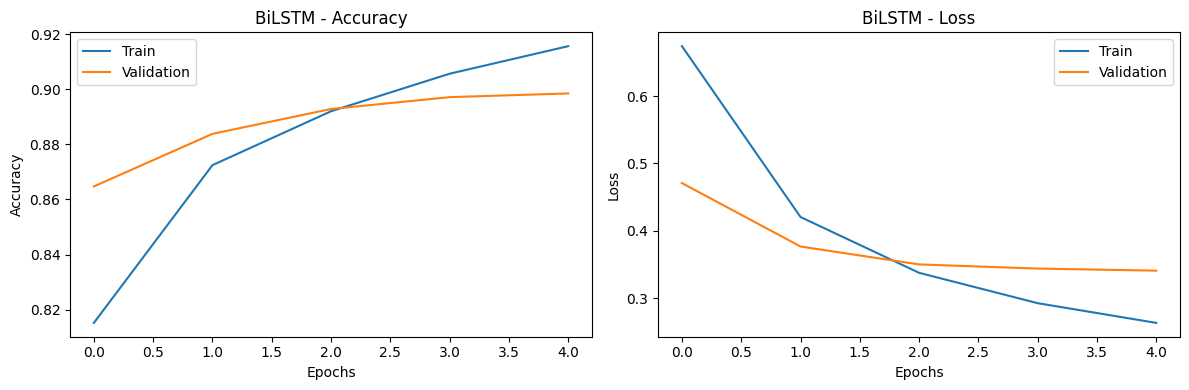


Making predictions for BiLSTM...
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 785ms/step
BiLSTM Accuracy: 0.6750
BiLSTM F1 Score (Macro): 0.4908
BiLSTM F1 Score (Weighted): 0.6699

Classification Report (Top 10 tags):
              precision    recall  f1-score   support

          NN       0.71      0.70      0.70     13757
         NNP       0.78      0.75      0.76     12846
          IN       0.72      0.72      0.72     12028
          DT       0.77      0.76      0.76      9783
          JJ       0.74      0.65      0.69      7586
         NNS       0.75      0.71      0.73      7117
           .       0.51      0.44      0.47       767
         VBD       0.76      0.67      0.71      3877
           ,       0.60      0.26      0.37      3192
         VBN       0.80      0.67      0.73      3273

   micro avg       0.74      0.69      0.71     74226
   macro avg       0.71      0.63      0.66     74226
weighted avg       0.74      0.69      0.71     74226



In [ ]:
print("\nTrying BiLSTM model...")
bilstm_model = build_bilstm_model()
bilstm_results = train_and_evaluate_model(bilstm_model, 'BiLSTM')
true_labels = bilstm_results['true_labels']
pred_labels = bilstm_results['pred_labels']
results.append(bilstm_results)

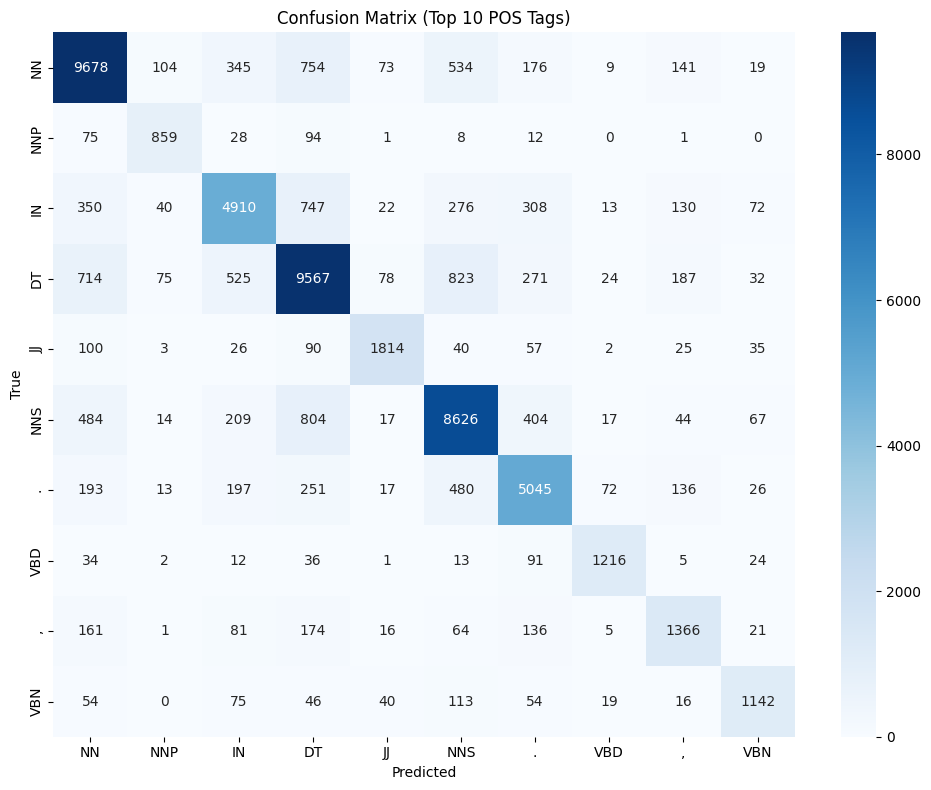

In [ ]:
# Top tag setup
idx_to_tag = {0: 'NN', 1: 'NNP', 2: 'IN', 3: 'DT', 4: 'JJ',
              5: 'NNS', 6: '.', 7: 'VBD', 8: ',', 9: 'VBN'}

top_indices = list(idx_to_tag.keys())
top_tags = [idx_to_tag[i] for i in top_indices]

# Filter for top tags only
mask_top = np.isin(true_labels, top_indices)
true_top = true_labels[mask_top]
pred_top = pred_labels[mask_top]

# Confusion matrix
cm = confusion_matrix(true_top, pred_top, labels=top_indices)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=top_tags,
            yticklabels=top_tags,
            cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 POS Tags)')
plt.tight_layout()
plt.show()



Model Performance Comparison:
     Model  Accuracy  F1 Macro  F1 Weighted
      LSTM  0.643172  0.452527     0.635770
       GRU  0.654384  0.473625     0.648154
    BiLSTM  0.675032  0.490772     0.669851
Simple_RNN  0.623503  0.444244     0.615669


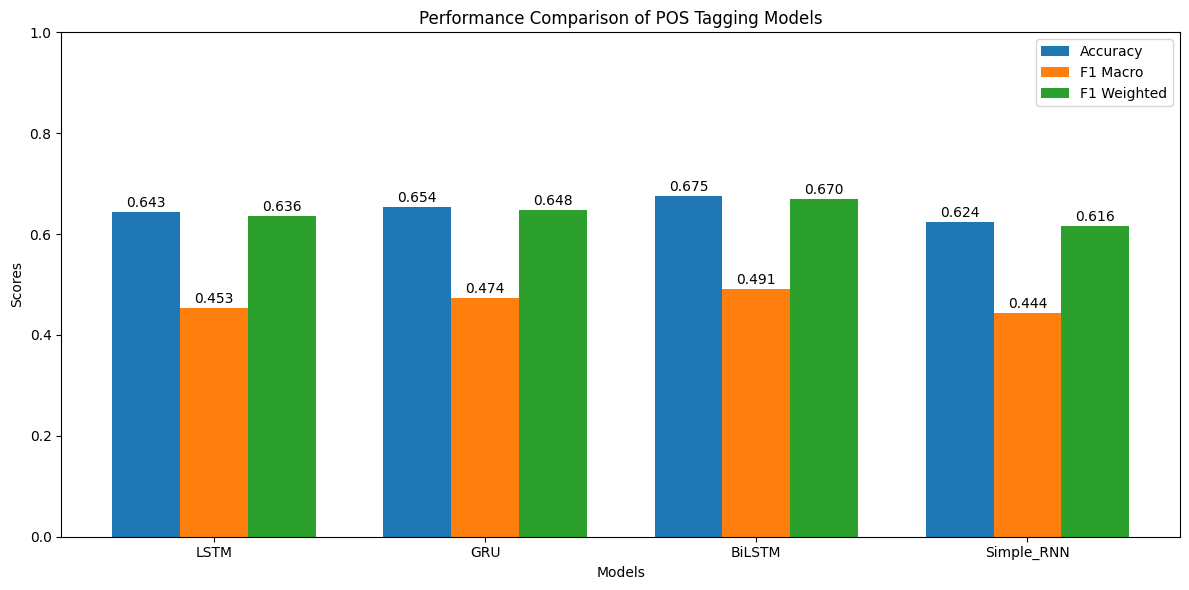


Best model: BiLSTM with F1 weighted score of 0.6699


In [ ]:
# Compare models
def compare_models(results):
    """Compare the performance of different models"""
    model_names = [result['model_name'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    f1_macro_scores = [result['f1_macro'] for result in results]
    f1_weighted_scores = [result['f1_weighted'] for result in results]

    # Create comparison table
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies,
        'F1 Macro': f1_macro_scores,
        'F1 Weighted': f1_weighted_scores
    })

    print("\nModel Performance Comparison:")
    print(results_df.to_string(index=False))

    # Create bar chart
    x = np.arange(len(model_names))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, accuracies, width, label='Accuracy')
    plt.bar(x, f1_macro_scores, width, label='F1 Macro')
    plt.bar(x + width, f1_weighted_scores, width, label='F1 Weighted')

    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Comparison of POS Tagging Models')
    plt.xticks(x, model_names)
    plt.legend()
    plt.ylim(0, 1)

    # Add value labels
    for i, v in enumerate(accuracies):
        plt.text(i - width, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_macro_scores):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(f1_weighted_scores):
        plt.text(i + width, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# Compare the models
compare_models(results)

# Identify the best model
best_model_idx = np.argmax([result['f1_weighted'] for result in results])
best_model = results[best_model_idx]['model_name']
best_score = results[best_model_idx]['f1_weighted']
print(f"\nBest model: {best_model} with F1 weighted score of {best_score:.4f}")

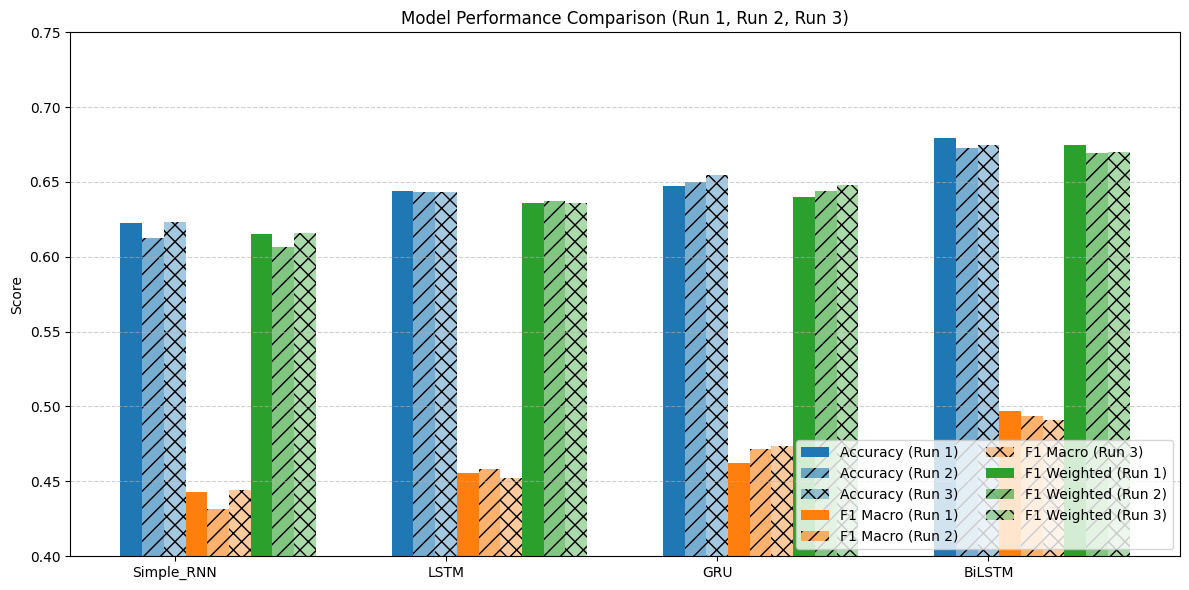

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and metrics
models = ['Simple_RNN', 'LSTM', 'GRU', 'BiLSTM']
metrics = ['Accuracy', 'F1 Macro', 'F1 Weighted']

# Metrics for Run 1
run1 = [
    [0.622870, 0.643804, 0.647242, 0.679694],     # Accuracy
    [0.442550, 0.455395, 0.462332, 0.497308],     # F1 Macro
    [0.615135, 0.636060, 0.640178, 0.674541]      # F1 Weighted
]

# Metrics for Run 2
run2 = [
    [0.612250, 0.643029, 0.649813, 0.673033],     # Accuracy
    [0.431380, 0.458356, 0.471647, 0.493804],     # F1 Macro
    [0.606336, 0.637084, 0.643816, 0.669304]      # F1 Weighted
]

# Model Performance Comparison (Run 3)
run3 = [
    [0.623503, 0.643172, 0.654384, 0.675032],     # Accuracy
    [0.444244, 0.452527, 0.473625, 0.490772],     # F1 Macro
    [0.615669, 0.635770, 0.648154, 0.669851]      # F1 Weighted
]

# Settings
x = np.arange(len(models))  # Model positions
width = 0.08  # Width of individual bars (smaller to fit more)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Colors and hatch patterns
colors = ['C0', 'C1', 'C2']
hatches = [None, '//', 'xx']

# Loop through metrics and plot all 3 runs
for i in range(len(metrics)):
    offset = i * 3 * width  # space each metric group
    ax.bar(x + offset - width, run1[i], width, label=f'{metrics[i]} (Run 1)', color=colors[i])
    ax.bar(x + offset, run2[i], width, label=f'{metrics[i]} (Run 2)', color=colors[i], alpha=0.6, hatch=hatches[1])
    ax.bar(x + offset + width, run3[i], width, label=f'{metrics[i]} (Run 3)', color=colors[i], alpha=0.4, hatch=hatches[2])

# Axis setup
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.set_ylabel('Score')
ax.set_ylim(0.4, 0.75)
ax.set_title('Model Performance Comparison (Run 1, Run 2, Run 3)')
ax.legend(loc='lower right', ncol=2)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
